In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy # Add Deepcopy for args

import seaborn as sns 
import matplotlib.pyplot as plt
import os, pickle, joblib, argparse

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from statsmodels.tsa.api import SimpleExpSmoothing
# pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
 
 
print(torch.__version__)
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (8, 6)

1.8.1+cu111
Populating the interactive namespace from numpy and matplotlib


In [107]:
# ================================================= #

# read file
raw_x_df = pd.read_csv('./data/train_x_df.csv')
raw_y_df = pd.read_csv('./data/train_y_df.csv')

print('Read files Complete!')
# ================================================= #


Read files Complete!


In [108]:
# ================================================= #
def df2d_to_array3d(df_2d):
    
    # 입력 받은 2차원 데이터 프레임을 3차원 numpy array로 변경하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    
    print('DataFrame to array, Complete!')
    
    return array_3d
# ================================================= #

def train_tset_spliter(arr):
    n = len(arr)
    num_features = arr.shape[2]
    
    train_arr = arr[0:int(n*0.8), :, :]
    val_arr = arr[int(n*0.8):, :, :]
    
    train_len = len(train_arr) 
    val_len = len(val_arr)
    
    print(
    f'''
    ======================================================
    Origin length is {n}, then total split length is {train_len, val_len}
    ======================================================
    train length is {train_arr.shape},
    val length is {val_arr.shape},
    num_features is ({num_features})
    '''
    )
    return train_arr, val_arr
# ================================================= #

def kbin_discretizer(input_array):

    kb = KBinsDiscretizer(n_bins=10, strategy='uniform', encode='ordinal')
    processed_data = np.zeros((input_array.shape[0], input_array.shape[1], 1))
    
    for i in range(input_array.shape[0]):
        # coin_index_export args : (input_array, coin_num)
        globals()['processing_array{}'.format(i)] = input_array[i,:,1]
        
        #globals()['outliery_array{}'.format(i)] = train_y_array[outlier[i],:,1]
        kb.fit(globals()['processing_array{}'.format(i)].reshape(input_array.shape[1],1))
        globals()['processed_fit{}'.format(i)] = kb.transform(globals()['processing_array{}'.format(i)].reshape(input_array.shape[1],1))
        
        #globals()['outliery_fit{}'.format(i)] = kb.transform(globals()['outliery_array{}'.format(i)].reshape(120,1))
        processed_data[i,:,:] = globals()['processed_fit{}'.format(i)]
        
    return processed_data

def outlier_detecter(raw_y_arr, outlier_criteria = 0.05):

    open_arr = raw_y_arr[:, :, 1] #open col is 1

    outlier_list = []
    openrange_list = []

    for idx, temp_arr in enumerate(open_arr):
    
        temp_min = temp_arr.min()
        temp_max = temp_arr.max()
        temp_arr_range = temp_max - temp_min
        openrange_list.append(temp_arr_range)

        if temp_arr_range > outlier_criteria:
            outlier_list.append(idx)
            print(f'{idx}번째 open series is outlier sample!')
            print(f'temp array range is {temp_arr_range:.3}\n')
            

    return outlier_list, np.array(openrange_list)

In [109]:
# df to array 
raw_x_arr = df2d_to_array3d(raw_x_df)
raw_y_arr = df2d_to_array3d(raw_y_df)

outlier_list, openrange_list = outlier_detecter(raw_y_arr, 0.0245)
# dis_x_arr = kbin_discretizer(raw_x_arr)
# dis_y_arr = kbin_discretizer(raw_y_arr)

# raw_x_arr[:, :, 1] = dis_x_arr.squeeze()
# dis_y_arr[:, :, 1] = dis_y_arr.squeeze()

DataFrame to array, Complete!
DataFrame to array, Complete!
2번째 open series is outlier sample!
temp array range is 0.0307

3번째 open series is outlier sample!
temp array range is 0.0278

4번째 open series is outlier sample!
temp array range is 0.0519

6번째 open series is outlier sample!
temp array range is 0.0524

9번째 open series is outlier sample!
temp array range is 0.0331

20번째 open series is outlier sample!
temp array range is 0.0308

27번째 open series is outlier sample!
temp array range is 0.0273

32번째 open series is outlier sample!
temp array range is 0.0582

40번째 open series is outlier sample!
temp array range is 0.0257

41번째 open series is outlier sample!
temp array range is 0.0283

45번째 open series is outlier sample!
temp array range is 0.0351

49번째 open series is outlier sample!
temp array range is 0.0343

50번째 open series is outlier sample!
temp array range is 0.0247

54번째 open series is outlier sample!
temp array range is 0.0359

58번째 open series is outlier sample!
temp array ra

3141번째 open series is outlier sample!
temp array range is 0.0303

3143번째 open series is outlier sample!
temp array range is 0.0519

3150번째 open series is outlier sample!
temp array range is 0.0329

3151번째 open series is outlier sample!
temp array range is 0.0278

3155번째 open series is outlier sample!
temp array range is 0.0601

3164번째 open series is outlier sample!
temp array range is 0.0616

3166번째 open series is outlier sample!
temp array range is 0.0308

3169번째 open series is outlier sample!
temp array range is 0.0292

3170번째 open series is outlier sample!
temp array range is 0.0258

3173번째 open series is outlier sample!
temp array range is 0.0553

3174번째 open series is outlier sample!
temp array range is 0.0364

3176번째 open series is outlier sample!
temp array range is 0.0255

3177번째 open series is outlier sample!
temp array range is 0.0363

3179번째 open series is outlier sample!
temp array range is 0.0363

3180번째 open series is outlier sample!
temp array range is 0.0454

3181번째 ope

In [110]:
raw_x_arr = np.delete(raw_x_arr, outlier_list, axis=0)
raw_y_arr = np.delete(raw_y_arr, outlier_list, axis=0)

# train test slit
train_x_arr, test_x_arr = train_tset_spliter(raw_x_arr)
train_y_arr, test_y_arr = train_tset_spliter(raw_y_arr)


    Origin length is 5744, then total split length is (4595, 1149)
    train length is (4595, 1380, 10),
    val length is (1149, 1380, 10),
    num_features is (10)
    

    Origin length is 5744, then total split length is (4595, 1149)
    train length is (4595, 120, 10),
    val length is (1149, 120, 10),
    num_features is (10)
    


In [111]:
# ================================================= #

def coin_index_export(input_array, coin_num):
    ''' 함수 설명 : 코인별 인덱스 뽑기 '''
    
    index = []
    sample_id_len = input_array.shape[0]
    coin_num_col = 0 

    for sample_id in range(sample_id_len):
        if input_array[sample_id, 0, coin_num_col] == coin_num:
            # print(sample_id)
            index.append(sample_id)
    return index

# ================================================= #

def each_coin_normalization(train_x_arr):
    ''' 함수 설명 : 코인별 데이터 정규화 '''
    
    # 유니크 코인 번호
    unique_coin_index = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    
    #create empty scaled list
    scaled_train_x_arr = np.zeros((train_x_arr.shape[0], train_x_arr.shape[1], train_x_arr.shape[2]))
    
    for temp_coin_num in unique_coin_index:
        # 유니크 코인 번호 중 한 코인 번호씩 해당 코인에 맞는 인덱스 추출
        # ex) if temp_coin_num is 0, temp_coin_index = [3, 7, 8, 14...]
        temp_coin_index = coin_index_export(train_x_arr, temp_coin_num)
        
        # temp coin num array export
        temp_x_arr = train_x_arr[temp_coin_index]
        
        # initialization
        num_sample   = temp_x_arr.shape[0] # sample dim
        num_sequence = temp_x_arr.shape[1] # time-sequence dim
        num_feature  = temp_x_arr.shape[2] # feature dim

        # create emptpy scaler
        temp_scaler = MinMaxScaler()
        
        # 시계열을 선회하면서 피팅합니다
        print('Current normalizing coin number is {}'.format(temp_coin_num))
        for temp_sample, temp_index in enumerate(temp_coin_index):
            temp_scaler.partial_fit(temp_x_arr[temp_sample, :, 5:]) # open =1, high = 2, low=3, close=4, volume=5 ~...

        # 스케일링(변환)합니다.
        for temp_sample, temp_index in enumerate(temp_coin_index):
            scaled_train_x_arr[temp_index, :, 5:] = temp_scaler.transform(temp_x_arr[temp_sample, :, 5:]).reshape(1, num_sequence, 5)
            scaled_train_x_arr[temp_index, :, :5] = temp_x_arr[temp_sample, :, :5]
            
        # save scaler for test arr
        dir_name = './scaler'
        file_name = f'coin_{temp_coin_num}_scaler.pkl'
        save_path = os.path.join(dir_name, file_name)
        joblib.dump(temp_scaler, save_path)
        
    
    print("Each coin normalization, Complete!")
    return scaled_train_x_arr

# ================================================= #

In [112]:
# train_x_arr, test_x_arr = train_tset_spliter(raw_x_arr)
# train_y_arr, test_y_arr = train_tset_spliter(raw_y_arr)

# 원래 하던 All coin 방식
# scaled_train_x_arr = each_coin_normalization(train_x_arr)

# 딥러닝 홀로서기의 normaliaztion 방식

In [113]:
# ================================================= #

def simple_exponetial_smoothing_fory(arr, alpha=0.3):
    
    y_series = list()

    for temp_arr in arr:
        target_series = temp_arr[:, 1].reshape(-1) # open col is 1 index

        smoother = SimpleExpSmoothing(target_series, initialization_method="heuristic").fit(smoothing_level=alpha,optimized=False)
        smoothing_series = smoother.fittedvalues

        y_series.append(smoothing_series)
            
    return np.array(y_series)

# ================================================= #

def simple_exponetial_smoothing_forX(arr, alpha=0.3):
    
    # initialization
    sample_size = int(arr.shape[0])
    time_size = int(arr.shape[1])
    feature_size = int(arr.shape[2])
    
    # create empty array
    smoothing_arr = np.zeros((sample_size, time_size, feature_size - 1))

    for idx, temp_arr in enumerate(arr):
        for col in range(1, feature_size): # open col is 1 index
            if col < 5:

                temp_series = temp_arr[:, col].reshape(-1) 
                smoother = SimpleExpSmoothing(temp_series, initialization_method="heuristic").fit(smoothing_level=0.3,optimized=False)
                temp_smoothing_series = smoother.fittedvalues
                smoothing_arr[idx, :, col-1] = temp_smoothing_series

            else:
                
                pass_series = temp_arr[:, col].reshape(-1)
                smoothing_arr[idx, :, col-1] = pass_series

    return smoothing_arr

# ================================================= #

In [114]:
# train set smoothing
train_x_arr = simple_exponetial_smoothing_forX(train_x_arr)
train_y_arr = simple_exponetial_smoothing_fory(train_y_arr)

# test set smoothing 
test_x_arr = simple_exponetial_smoothing_forX(test_x_arr)
test_y_arr = simple_exponetial_smoothing_fory(test_y_arr)

# print('simple exponetial smoothing Complete!!!')

In [115]:
print(
    f'''
    train x shape is {train_x_arr.shape},
    train y shape is {train_y_arr.shape},

    
    test x shape is {test_x_arr.shape},
    test y shape is {test_y_arr.shape},
    '''
)


    train x shape is (4595, 1380, 9),
    train y shape is (4595, 120),

    
    test x shape is (1149, 1380, 9),
    test y shape is (1149, 120),
    


In [116]:
# # train & val set
# train_X, val_X, train_y, val_y = train_test_split(train_x_arr[:, :, 1:], train_y_arr[:, :, 1], test_size=0.1, shuffle=False)

# # test set
# # test_X = test_x_arr[:, :, 1:] # open col
# # test_y = test_y_arr

# print(
# f'''
# ======================================================
# Origin length is {len(train_x_arr)}, then total split length is {len(train_X)} + {len(val_X)} = {len(train_X)+len(val_X)}
# ======================================================
# train X length is {train_X.shape}, train y length is {train_y.shape},
# val X length is {val_X.shape}, val y length is {val_y.shape},
# '''
# # test X length is {test_X.shape}, test y length is {test_y.shape}
# )

In [125]:
# ====== initialization
parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device is",args.device)

seed = 777
np.random.seed(seed)
torch.manual_seed(seed)


# ====== Model Capacity options ===== #
args.input_dim = 9
args.hidden_dim = 200
args.output_dim = 1
args.n_layers = 1
args.batch_size = 32
args.dropout = 0.2
args.use_bn = True

# ====== Dataset Generating options ====== #
args.x_frames = 360
args.y_frames = 120

# ====== Model training options ===== #
args.num_epoch = 50
args.learning_rate = 0.001
args.L2_rate = 0.0001


device is cuda


In [126]:
class WindowGenerator():
    ''' Dataset Generate'''
    def __init__(self, X_arr, y_arr, x_frames):
    
        self.X_arr = X_arr
        self.y_arr = y_arr
        self.x_frames = x_frames
        
        
    def __repr__(self):
        return '\n'.join([
            f'Input indices: {self.X_arr.shape}',
            f'Label indices: {len(self.y_arr)}',
            f'Current column name(s): {self.x_frames}'
        ])

    def __len__(self):
        return len(self.y_arr)

    def __getitem__(self, idx):
        
        X = self.X_arr[idx, -self.x_frames:, :]
        X = np.log(X + 1) - np.log(X[-1, :] + 1)
        
        y = self.y_arr[idx, :]
        y = np.log(y + 1) -  np.log(X[-1, 0] + 1)
        
        return X, y

In [127]:
class LSTM(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout, use_bn):
        super(LSTM, self).__init__()
        self.input_dim = input_dim 
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers

        self.dropout = dropout
        self.use_bn = use_bn 
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)

        self.regressor = self.make_regressor()
        
    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, batch_size, self.hidden_dim))
    
    def make_regressor(self):
        layers = []
        if self.use_bn:
            layers.append(nn.BatchNorm1d(self.hidden_dim))
        layers.append(nn.Dropout(self.dropout))
        
        layers.append(nn.Linear(self.hidden_dim, 200))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(200, self.output_dim))
        regressor = nn.Sequential(*layers)
        return regressor
    
    def forward(self, X):
        lstm_out, self.hidden = self.lstm(X)
        y_pred = self.regressor(lstm_out[-1].view(X.shape[1], -1))
        return y_pred
    
def metric(y_pred, y_true):
    perc_y_pred = np.exp(y_pred.cpu().detach().numpy())
    perc_y_true = np.exp(y_true.cpu().detach().numpy())
    mae = mean_absolute_error(perc_y_true, perc_y_pred, multioutput='raw_values')
    return mae*100

    
def train(model, partition, optimizer, loss_fn, args):
    ''' model training '''
   
    # data load
    trainloader = DataLoader(partition['train'],
                             batch_size = args.batch_size,
                             shuffle = True, drop_last = True)
    
    # model's mode setting
    model.train()
    model.zero_grad()
    optimizer.zero_grad()
    
    train_loss = 0.0
    train_acc = 0.0
    for i, (X, y) in enumerate(trainloader):
    
        X = X.transpose(0, 1).float().to(args.device)
        y_true = y.float().to(args.device)
        
#         print(X.shape, y_true.shape)
        
        # zero the gradient
        model.zero_grad()
        optimizer.zero_grad()
        model.hidden = model.init_hidden(X.shape[1])

        y_pred = model(X)
#         print(y_pred.shape)
        
        loss = loss_fn(y_true.view(-1), y_pred.view(-1))
        loss.backward()
        optimizer.step()
        
#         print('here')
        # get the batch loss
        train_loss += loss.item()
        train_acc += metric(y_pred, y_true)[0]
        
    train_loss = train_loss / len(trainloader)
    train_acc = train_acc / len(trainloader)
    return model, train_loss, train_acc


def validate(model, partition, loss_fn, args):
    ''' model validate '''
    
    # data load
    valloader = DataLoader(partition['val'], 
                           batch_size = args.batch_size, 
                           shuffle = False, drop_last = True)
    
    # model's mode setting
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    # evaluate
    with torch.no_grad():
        for i, (X, y) in enumerate(valloader):
            
            X = X.transpose(0, 1).float().to(args.device)
            y_true = y.float().to(args.device)
            
            model.hidden = model.init_hidden(X.shape[1])
            # en-decoder outputs tensor 
            y_pred = model(X)
            # compute the loss 
            loss = loss_fn(y_true.view(-1), y_pred.view(-1))

            # get the batch loss
            val_loss += loss.item()
            val_acc += metric(y_pred, y_true)[0]
            
    val_loss = val_loss / len(valloader)
    val_acc = val_acc * len(valloader)
    return val_loss, val_acc



def experiment(partition, args):


    model = LSTM(args.input_dim, args.hidden_dim, args.y_frames, args.n_layers, args.dropout, args.use_bn)
    model.to(args.device)
    
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.L2_rate)
    
    # epoch-wise loss
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    for epoch in range(args.num_epoch):
        
        start_time = time.time()
        model, train_loss, train_acc= train(model, partition, optimizer, loss_fn, args)
        val_loss, val_acc = validate(model, partition, loss_fn, args)
        end_time = time.time()
        
        # add epoch loss
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.5f}/{:2.5f}. Took {:2.2f} sec'.format(
            epoch+1, train_acc, val_acc, train_loss*10E3, val_loss*10E3, end_time-start_time))
    

    # ======= Add Result to Dictionary ======= #
    result = {}
    
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    
    return vars(args), result, model

In [128]:
trainset = WindowGenerator(train_x_arr, train_y_arr, x_frames = args.x_frames)
valset = WindowGenerator(test_x_arr, test_y_arr, x_frames = args.x_frames)
# testset = WindowGenerator(test_X, test_y, x_frames = args.x_frames)

partition = {'train': trainset, 'val':valset}

In [129]:
print(args)
setting, result, model = experiment(partition, deepcopy(args))

Namespace(L2_rate=0.0001, batch_size=32, device='cuda', dropout=0.2, hidden_dim=200, input_dim=9, learning_rate=0.001, n_layers=1, num_epoch=50, output_dim=1, use_bn=True, x_frames=360, y_frames=120)
Epoch 1, Acc(train/val): 27.42/17736.94, Loss(train/val) 439.42412/46.64058. Took 4.80 sec
Epoch 2, Acc(train/val): 18.86/11676.71, Loss(train/val) 154.81277/52.18711. Took 4.75 sec
Epoch 3, Acc(train/val): 14.58/6908.31, Loss(train/val) 95.27232/17.20645. Took 4.73 sec
Epoch 4, Acc(train/val): 12.81/7630.20, Loss(train/val) 72.16980/12.47286. Took 4.76 sec
Epoch 5, Acc(train/val): 11.46/4666.26, Loss(train/val) 56.77588/7.32672. Took 4.75 sec
Epoch 6, Acc(train/val): 9.90/8396.43, Loss(train/val) 43.62497/22.82044. Took 4.77 sec
Epoch 7, Acc(train/val): 9.76/6502.09, Loss(train/val) 42.65753/12.42105. Took 4.77 sec
Epoch 8, Acc(train/val): 8.02/5837.24, Loss(train/val) 29.07647/10.91441. Took 4.76 sec
Epoch 9, Acc(train/val): 7.31/4707.20, Loss(train/val) 25.08651/5.33660. Took 4.75 sec
E

(120,) (120,)


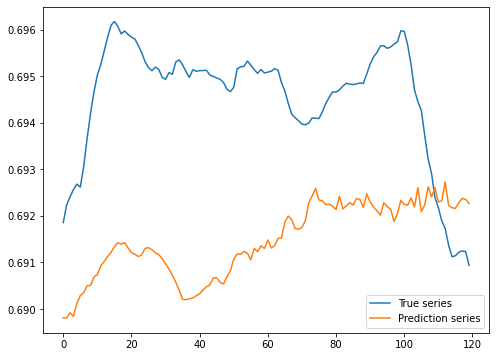

(120,) (120,)


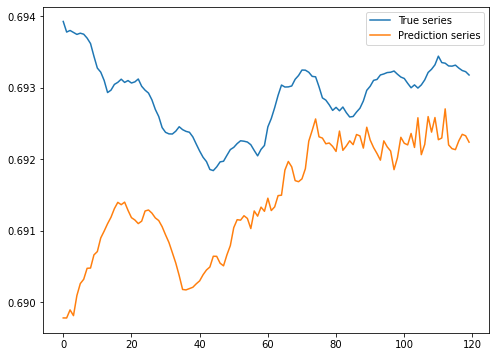

(120,) (120,)


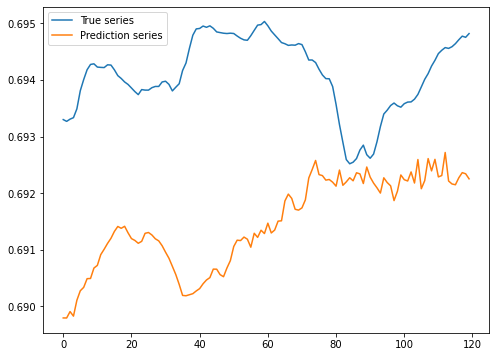

(120,) (120,)


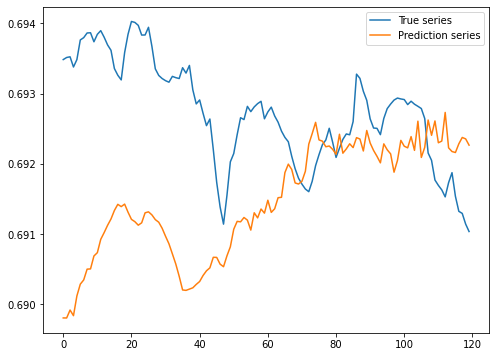

(120,) (120,)


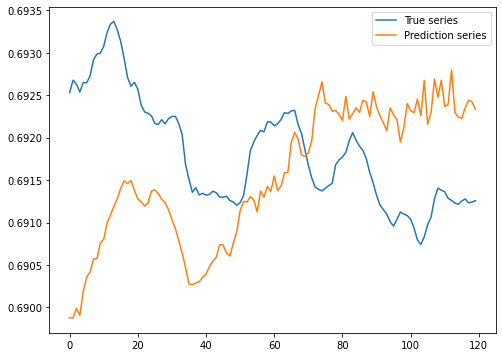

(120,) (120,)


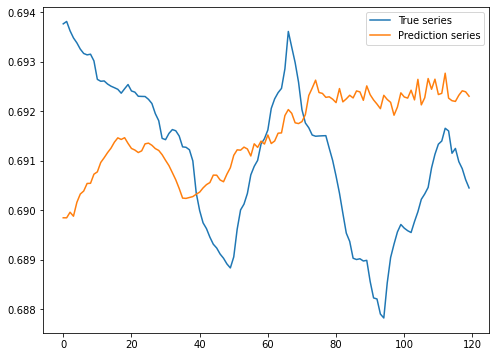

(120,) (120,)


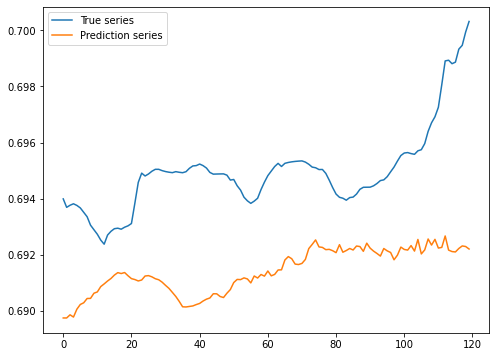

(120,) (120,)


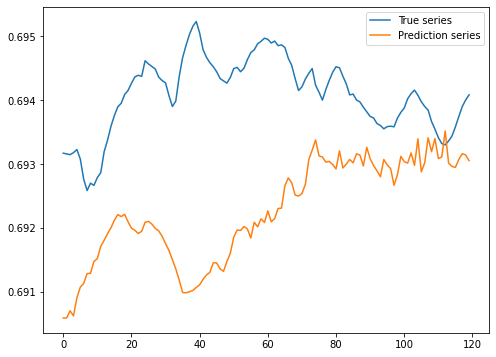

(120,) (120,)


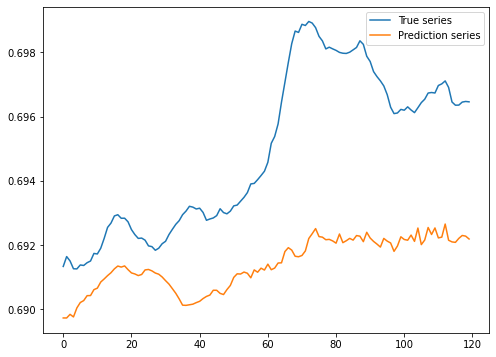

(120,) (120,)


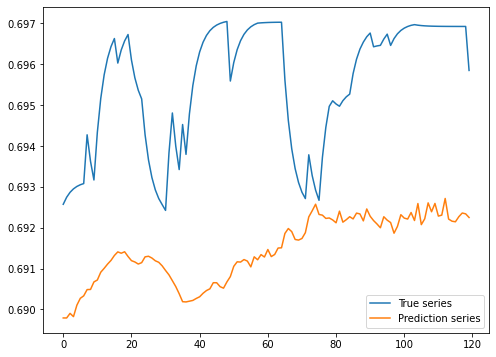

(120,) (120,)


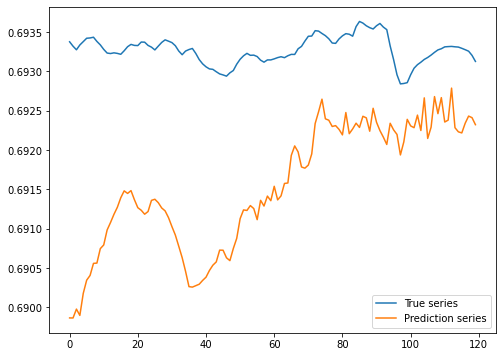

Namespace(L2_rate=0.0001, batch_size=32, device='cuda', dropout=0.2, hidden_dim=200, input_dim=9, learning_rate=0.001, n_layers=1, num_epoch=50, output_dim=1, use_bn=True, x_frames=360, y_frames=120) 
SES 사용
mean absolute error * 10E5 is 346.2765598669648


In [130]:
testloader = DataLoader(partition['train'], batch_size = 1, shuffle = True, drop_last = True)
model.eval()
# evaluate

with torch.no_grad():
    for i, (X, y) in enumerate(testloader):

        X = X.transpose(0, 1).float().to(args.device)
        y_true = y.float().to(args.device)
        model.hidden = model.init_hidden(X.shape[1])

        # en-decoder outputs tensor 
        y_pred = model(X)
        
        # y values to cpu
        y_true = y_true.cpu().detach().numpy().reshape(-1)
        y_pred = y_pred.cpu().detach().numpy().reshape(-1)
        
        print(y_true.shape, y_pred.shape)

        plt.plot(y_true, label = 'True series')
        plt.plot(y_pred, '-', label = 'Prediction series')
#         plt.plot(.max(), '*')
        plt.legend()
        plt.show()

        loss = mean_absolute_error(y_true, y_pred)
        mae =+ loss
        if i == 10:
            print(args, "\nSES 사용")
            print(f'mean absolute error * 10E5 is {(mae/5) * 10E5}')            
            break
